In [8]:
import pandas as pd
# ozone.csv 파일을 엑셀로 열어서 Ozone2 필드 추가(결측값을 평균으로 채움)
# =IF(A2="NA",AVERAGE($A$2:$A$154),A2)
df = pd.read_csv('c:/data/ozone/ozone2.csv')
df

,Ozone,Result,Solar.R,Wind,Temp,Month,Day
0,41.00000,0,190.000000,7.4,67,5,1
1,36.00000,0,118.000000,8.0,72,5,2
2,12.00000,0,149.000000,12.6,74,5,3
3,18.00000,0,313.000000,11.5,62,5,4
4,42.12931,0,185.931507,14.3,56,5,5
...,...,...,...,...,...,...,...
148,30.00000,0,193.000000,6.9,70,9,26
149,42.12931,0,145.000000,13.2,77,9,27
150,14.00000,0,191.000000,14.3,75,9,28
151,18.00000,0,131.000000,8.0,76,9,29


<AxesSubplot:>

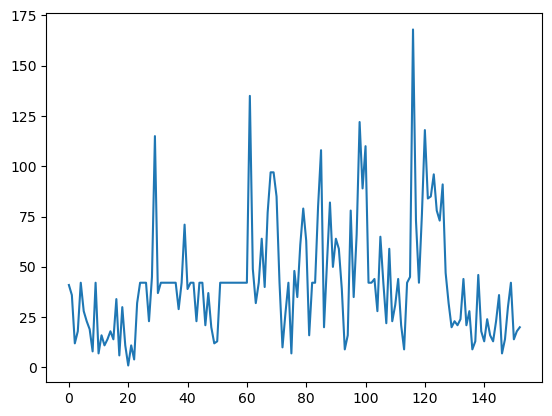

In [9]:
df['Ozone'].plot()

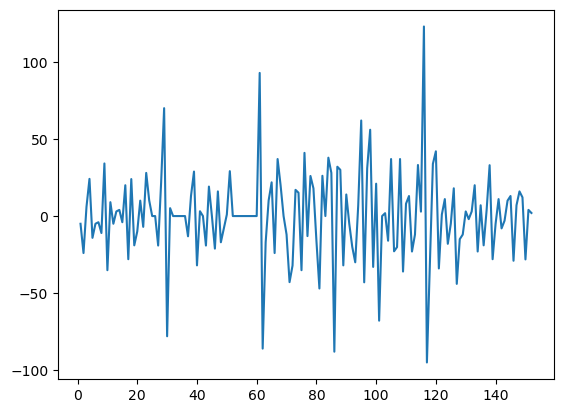

In [10]:
#1차 차분 데이터
import matplotlib.pyplot as plt
diff1=df['Ozone'].diff(periods=1).iloc[1:]
diff1.plot()
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
#로그 후 차분한 자료를 adfuller 함수로 안정적인 시계열인지 확인
diff1=np.log(df['Ozone']).diff(periods=1).iloc[1:]
result=adfuller(diff1)
print(result)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#p-value가 0.05보다 작으므로 95% 신뢰수준 하에서 유의함(안정적인 시계열 자료임)

(-9.189875590807725, 2.1375829069820617e-15, 3, 148, {'1%': -3.4753253063120644, '5%': -2.881274703275226, '10%': -2.5772928360116873}, 289.55299349906795)
ADF Statistic: -9.189876
p-value: 0.000000


In [14]:
from pmdarima.arima import auto_arima
model = auto_arima(df['Ozone'],suppress_warnings=True)
model
#가장 적절한 모형은 arima(1,0,1)

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True)

In [16]:
#학습용,검증용 구분
n=int(df.shape[0]*.8)
train = df[:n]
test = df[n:]
print(len(df['Ozone']))
print(train['Ozone'].values)
print(test['Ozone'].values)

153
[ 41.          36.          12.          18.          42.12931034
  28.          23.          19.           8.          42.12931034
   7.          16.          11.          14.          18.
  14.          34.           6.          30.          11.
   1.          11.           4.          32.          42.12931034
  42.12931034  42.12931034  23.          45.         115.
  37.          42.12931034  42.12931034  42.12931034  42.12931034
  42.12931034  42.12931034  29.          42.12931034  71.
  39.          42.12931034  42.12931034  23.          42.12931034
  42.12931034  21.          37.          20.          12.
  13.          42.12931034  42.12931034  42.12931034  42.12931034
  42.12931034  42.12931034  42.12931034  42.12931034  42.12931034
  42.12931034 135.          49.          32.          42.12931034
  64.          40.          77.          97.          97.
  85.          42.12931034  10.          27.          42.12931034
   7.          48.          35.          61.          

In [17]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['Ozone'], order=(1,0,1)).fit()
predictions = model.predict(start=1, end=len(test), dynamic=False)
predictions.index=len(train)+(predictions.index-1)
predictions

122    43.289107
123    41.239720
124    32.405635
125    31.380874
126    39.214561
127    37.155501
128    34.739042
129    32.537125
130    28.034224
131    38.045190
132    29.619166
133    29.730128
134    28.071797
135    28.510682
136    30.021694
137    29.191920
138    35.690410
139    28.457053
140    34.075991
141    29.590118
142    24.628687
143    26.289499
144    24.493803
145    33.370182
146    39.909422
147    42.194047
148    42.992230
149    36.778233
150    42.074466
151    67.684182
152    50.156772
Name: predicted_mean, dtype: float64

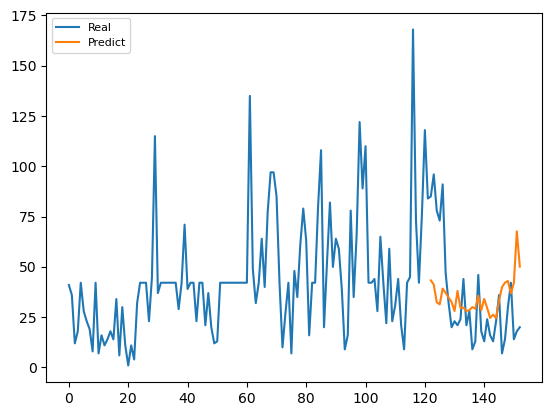

In [18]:
plt.plot(df['Ozone'],label='Real')
plt.plot(predictions,label='Predict')
plt.legend(loc='upper left',fontsize=8)
plt.show()

In [19]:
import numpy as np

def _error(real, pred):
    return real - pred

def mse(real, pred):
    return np.mean(np.square(_error(real, pred)))

def rmse(real, pred):
    return np.sqrt(mse(real, pred))

def mae(real, pred):
    return np.mean(np.abs(_error(real, pred)))
METRICS = {
    "mse": mse,
    "rmse": rmse,
    "mae": mae,
}

def evaluate(real, pred, metrics=("mse", "rmse", "mae")):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](real, pred)
        except:
            results[name] = np.nan
    return results

In [20]:
evaluate(test['Ozone'].values, predictions.values)

{'mse': 644.8724945214616,
 'rmse': 25.39433981267207,
 'mae': 19.619099075527128}